In [16]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers
from tensorflow import keras
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import cv2
from pathlib import Path
from tqdm import tqdm
import os

In [17]:
# Define directories
input_dirs = {
    "train": "/kaggle/input/ucf101-action-recognition/train",
    "test": "/kaggle/input/ucf101-action-recognition/test",
    "val": "/kaggle/input/ucf101-action-recognition/val",
}
output_dir = "/kaggle/working/processed_data/"


In [18]:
# Create output directory structure
subcategories = ["HorseRiding", "PlayingDhol", "PushUps", "BenchPress", "PlayingGuitar"]
for dataset in ["train", "test", "val"]:
    for category in subcategories:
        Path(os.path.join(output_dir, dataset, category)).mkdir(parents=True, exist_ok=True)


In [19]:
def process_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Get video frame dimensions
    ret, frame = cap.read()
    if not ret:
        cap.release()
        print(f"Error reading {video_path}")
        return
    height, width, _ = frame.shape
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to the first frame

    # Prepare video writer with single channel grayscale output
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (64, 64), isColor=False)

    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        # Convert to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Resize to 64x64
        resized_frame = cv2.resize(gray_frame, (64, 64))
        # Ensure the frame is single-channel (grayscale)
        resized_frame = resized_frame.astype('uint8')  # Ensure data type
        # Write the frame to output (1 channel)
        out.write(resized_frame)

    cap.release()
    out.release()

In [20]:
# Process each file
for dataset, input_dir in input_dirs.items():
    print(f"Processing {dataset} dataset:")
    for category in subcategories:
        category_path = os.path.join(input_dir, category)
        if not os.path.exists(category_path):
            continue
        
        video_files = [f for f in os.listdir(category_path) if f.endswith(".avi")]
        for file_name in tqdm(video_files, desc=f"Processing {category}", leave=False):
            input_path = os.path.join(category_path, file_name)
            output_path = os.path.join(output_dir, dataset, category, file_name)
            process_video(input_path, output_path)

Processing train dataset:


Processing test dataset:


Processing val dataset:


In [21]:
video_dirs = {
    "train": "/kaggle/working/processed_data/train",
    "test": "/kaggle/working/processed_data/test",
    "val": "/kaggle/working/processed_data/val",
}
subcategories = ["HorseRiding", "PlayingDhol", "PushUps", "BenchPress", "PlayingGuitar"]

# Function to load videos from .avi files
def load_videos_from_avi(directory, categories, num_frames):
    data = []
    for category in categories:
        category_path = os.path.join(directory, category)
        if not os.path.exists(category_path):
            continue
        for file_name in tqdm(os.listdir(category_path), desc=f"Loading {category}"):
            if not file_name.endswith(".avi"):
                continue
            video_path = os.path.join(category_path, file_name)
            cap = cv2.VideoCapture(video_path)
            frames = []
            while len(frames) < num_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                # Convert to grayscale and drop the redundant channels
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frames.append(gray_frame)  # Only append single-channel (grayscale) frame
            cap.release()
            if len(frames) == num_frames:  # Ensure uniform number of frames
                video_array = np.array(frames, dtype=np.uint8)
                data.append(video_array)
    return np.array(data, dtype=np.uint8)

# Parameters
NUM_FRAMES = 20  # Expected number of frames per video

# Load datasets
print("Loading datasets...")
train_dataset = load_videos_from_avi(video_dirs["train"], subcategories, NUM_FRAMES)
val_dataset = load_videos_from_avi(video_dirs["val"], subcategories, NUM_FRAMES)
test_dataset = load_videos_from_avi(video_dirs["test"], subcategories, NUM_FRAMES)

# Add a channel dimension (for grayscale videos)
train_dataset = np.expand_dims(train_dataset, axis=-1)
val_dataset = np.expand_dims(val_dataset, axis=-1)
test_dataset = np.expand_dims(test_dataset, axis=-1)

# Normalize the data (if needed)
train_dataset = train_dataset / 255.0
val_dataset = val_dataset / 255.0
test_dataset = test_dataset / 255.0

# Define a helper function to shift the frames
def create_shifted_frames(data):
    x = data[:, :-1, :, :]  # All frames except the last
    y = data[:, 1:, :, :]   # All frames except the first
    return x, y

# Create shifted datasets
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
x_test, y_test = create_shifted_frames(test_dataset)

# Inspect the dataset
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))
print("Test Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))


Loading datasets...


Loading PlayingGuitar: 100%|██████████| 20/20 [00:00<00:00, 376.06it/s]


Training Dataset Shapes: (562, 19, 64, 64, 1), (562, 19, 64, 64, 1)
Validation Dataset Shapes: (93, 19, 64, 64, 1), (93, 19, 64, 64, 1)
Test Dataset Shapes: (95, 19, 64, 64, 1), (95, 19, 64, 64, 1)


In [22]:
len(train_dataset)

562

Displaying frames for example 177.


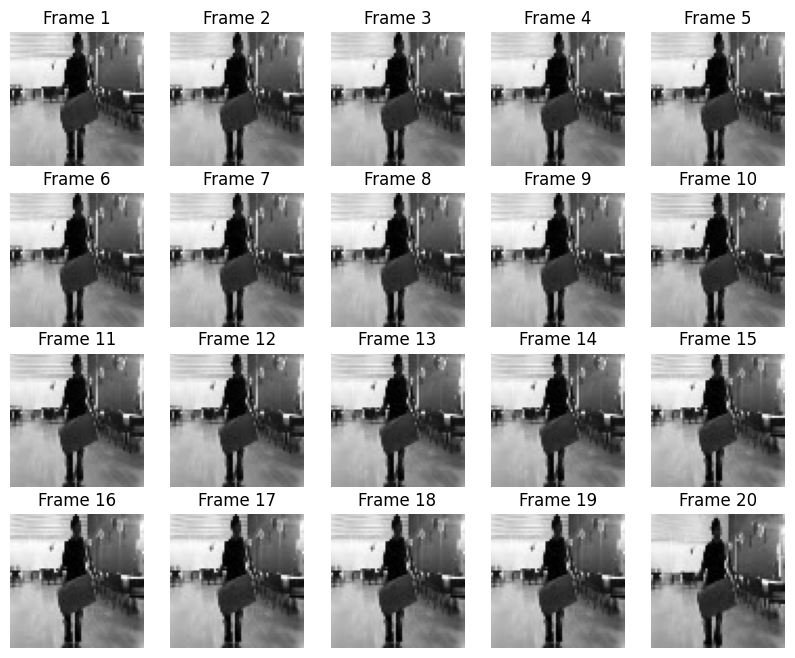

In [23]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [24]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [25]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)



# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

# Save directories
MODEL_SAVE_DIR = "/kaggle/working/"
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "predrnn_model.h5")
WEIGHTS_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "predrnn_weights.weights.h5")

# Save the full model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Save the weights
model.save_weights(WEIGHTS_SAVE_PATH)
print(f"Model weights saved to {WEIGHTS_SAVE_PATH}")


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 386ms/step - accuracy: 0.0702 - loss: 0.5617 - val_accuracy: 0.0499 - val_loss: 0.6724 - learning_rate: 0.0010
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 343ms/step - accuracy: 0.0647 - loss: 0.5130 - val_accuracy: 0.0501 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - accuracy: 0.0682 - loss: 0.5067 - val_accuracy: 0.0506 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 343ms/step - accuracy: 0.0786 - loss: 0.4926 - val_accuracy: 0.0539 - val_loss: 0.6133 - learning_rate: 0.0010
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - accuracy: 0.0648 - loss: 0.4904 - val_accuracy: 0.0550 - val_loss: 0.5524 - learning_rate: 0.0010
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - accuracy: 0.0653 - loss: 0.4970 - val_accuracy: 0.0550 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - accuracy: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


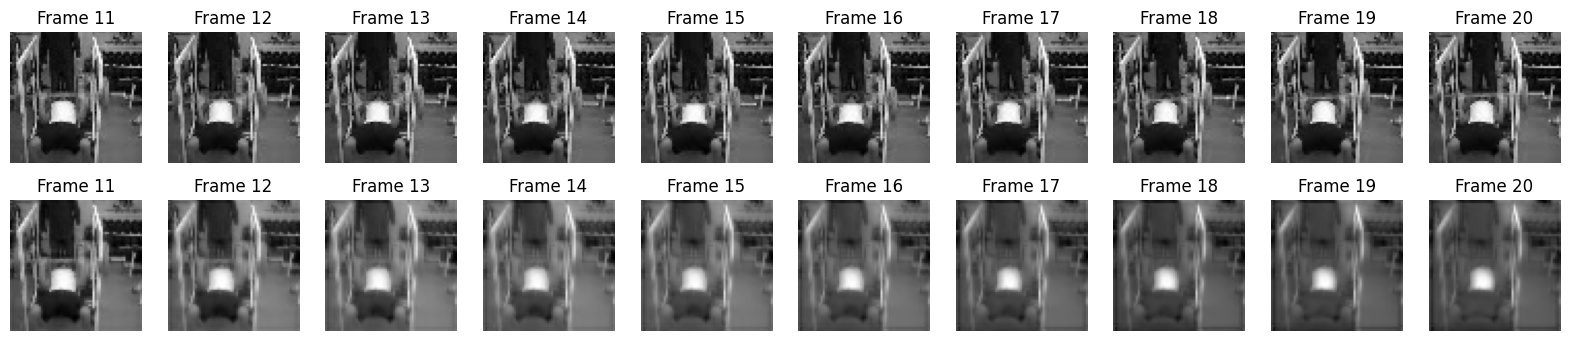

In [26]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...] # first 10 frames
original_frames = example[10:, ...] # last 10 frames

# Predict a new set of 10 frames using the last 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [30]:
import imageio
import io
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Create a directory to save the GIFs if it doesn't exist
save_dir = 'predicted_gifs'
os.makedirs(save_dir, exist_ok=True)

# Iterate over the examples and predict the frames.
predicted_videos = []
for example_idx, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Initialize lists to store SSIM and MSE scores for original and predicted frames
    ssim_scores = []
    mse_scores = []

    # Calculate SSIM and MSE between original and predicted frames
    for i in range(10):
        original_frame = original_frames[i]
        predicted_frame = new_predictions[i]
        
        # Convert frames to grayscale (if they are color images)
        original_gray = np.mean(original_frame, axis=-1)
        predicted_gray = np.mean(predicted_frame, axis=-1)

        # Compute SSIM for the current frame
        ssim_score, _ = ssim(original_gray, predicted_gray, full=True, data_range=original_gray.max() - original_gray.min())
        ssim_scores.append(ssim_score)

        # Compute MSE for the current frame
        mse_score = mean_squared_error(original_gray.flatten(), predicted_gray.flatten())
        mse_scores.append(mse_score)

    # Calculate average SSIM and MSE for both original and predicted frames
    avg_ssim = np.mean(ssim_scores)
    avg_mse = np.mean(mse_scores)

    # Display SSIM and MSE for the current example
    print(f"Example {example_idx}:")
    print(f"  - Average SSIM for original frames: {avg_ssim:.4f}")
    print(f"  - Average MSE for predicted frames: {avg_mse:.4f}")

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Save the GIF to a file
        gif_type = 'truth' if frame_idx == 0 else 'prediction'
        gif_path = os.path.join(save_dir, f'example_{example_idx}_{gif_type}.gif')
        imageio.mimsave(gif_path, current_frames, "GIF", duration=200)
        
        # Also store in memory for display
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

print(f"\nGIFs have been saved to the '{save_dir}' directory")


import matplotlib.pyplot as plt

# Assuming the model's training history is stored in the 'history' variable
history = model.history



# Plotting training and validation accuracy
# Note: Replace 'accuracy' and 'val_accuracy' with the correct key names if your model uses a different metric name.
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['loss'], label='Training Loss', color='purple')
plt.title('Training Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('/kaggle/working/result.png')
print("Plot saved as result.png")
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Example 0:
  - Average SSIM for original frames: 0.9593
  - Average MSE for predicted frames: 0.0015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Example 1:
  - Average SSIM for original frames: 0.9356
  - Average MSE for predicted frames: 0.0023
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



GIFs have been saved to the 'predicted_gifs' directory


KeyError: 'accuracy'

<Figure size 800x600 with 0 Axes>